In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

## Goal: 
1. predict employee retention
2. understand its main drivers.

# 1. Data Preview

In [2]:
# Load the conversion project dataset
data = pd.read_csv("employee_retention.csv",sep=",")
# Let us first develop a preview of the conversion dataset
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
# Exploring the data types, number of unique values and missing values
print(f"The employee retention dataset (2011/01/24 to 2015/12/13) \nconsists of {data.shape[0]} rows and {data.shape[1]} columns, with 11192 missing values in quit_date\n")
pd.DataFrame({"data_types":data.dtypes, 
          "value_counts": data.nunique(),
          "null_counts": data.isnull().sum()}).set_index(data.dtypes.index)

The employee retention dataset (2011/01/24 to 2015/12/13) 
consists of 24702 rows and 7 columns, with 11192 missing values in quit_date



,data_types,value_counts,null_counts
employee_id,float64,24702,0
company_id,int64,12,0
dept,object,6,0
seniority,int64,31,0
salary,float64,367,0
join_date,object,995,0
quit_date,object,664,11192


In [4]:
# Next, let's take a look at the descriptive statistics
print("For numeric variables: \n",data.describe(),"\n")
print("For categorical variables: \n", data.describe(include = "object"))

For numeric variables: 
          employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  408000.000000 

For categorical variables: 
                     dept   join_date   quit_date
count              24702       24702       13510
unique                 6         995         664
top     customer_service  2012-01-03  2015-05-08
freq                9180         105         111


# 2. Data Cleaning

### 2-1. Seniority and Salary
Since "new_user" and "convered" are essentially label columns with only 2 unique values of 1 and 0. Here I focus on removing outliers within "seniority" and "salary" columns

While the distribution of salary comforms relatively to our common sense, two seniority of about 100 years are doomed to be erroneous


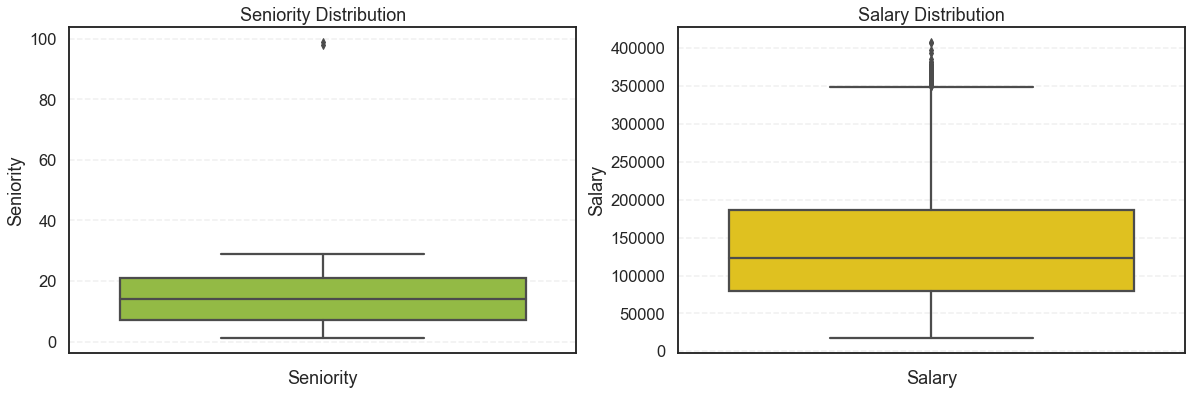

In [5]:
# Create the axes and figure 
f, axes = plt.subplots(1, 2, figsize = (20,6)) 
plt.rcParams['font.sans-serif']=['Arial']

# Create the boxplots. Assign the ax keyword argument
sns.boxplot(data = data.seniority ,ax=axes[0], color = "yellowgreen")
sns.boxplot(data = data.salary, ax= axes[1], color = "gold")

axes[0].set_title("Seniority Distribution")
axes[0].set_ylabel("Seniority")
axes[0].set_xlabel("Seniority")
axes[0].set_xticklabels("")
axes[0].grid(axis = "y", linestyle="--", alpha=0.3)

axes[1].set_title("Salary Distribution")
axes[1].set_ylabel("Salary")
axes[1].set_xlabel("Salary")
axes[1].set_xticklabels("")
axes[1].grid(axis = "y", linestyle="--", alpha=0.3)

print("While the distribution of salary comforms relatively to our common sense, two seniority of about 100 years are doomed to be erroneous")

In [6]:
# Take a glance at the outlier records
data[data.seniority > 80]

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052.0,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [7]:
# Remove the erroneous outliers in Seniority
data = data.loc[data.seniority < 80, :]

### 2-2. Date
(1) Convert both the join_date and quit_date into datetime datatype, and replace N/A with "2015-12-13" (the last day in our measure); In order to account for the fact that these employee are not quitting, here I include another column to demonstrate whether an employee churns or not

In [8]:
# Create a new column: is_churn (1 if churn and 0 not churn)
data["is_churn"] = 1
data.loc[data.quit_date.isna(),"is_churn"] = 0

# Convert join_date and quit_date to datetime
data.join_date = list(map(lambda day: date.fromisoformat(day),data.join_date))
data.quit_date = list(map(lambda day: date.fromisoformat(day),data.quit_date.fillna("2015-12-13")))

(2) Also, I include a tenure column by taking the difference between the two dates, and measured in months

In [9]:
data["tenure"] = list(map(lambda first_day,last_day: rrule.rrule(rrule.MONTHLY, dtstart = first_day, until = last_day).count(),
         data.join_date,data.quit_date))

(3) I also extract year and month information from the two date column in order to drill deeper

In [10]:
data["join_year"] = list(map(lambda day:day.year, data.join_date))
data["join_month"] = list(map(lambda day:day.month, data.join_date))
data["quit_year"] = list(map(lambda day:day.year, data.quit_date))
data["quit_month"] = list(map(lambda day:day.month, data.quit_date))

In [11]:
# check the result
data.head(3)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,is_churn,tenure,join_year,join_month,quit_year,quit_month
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,20,2014,3,2015,10
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,11,2013,4,2014,4
2,927315.0,4,marketing,14,101000.0,2014-10-13,2015-12-13,0,15,2014,10,2015,12


# 3. Exploratory Data Analysis

### 3-1. Multi-variate Correlations

Most variables are not correlated with each other, except for the salary. According to our dataset, different departments, companies, and seniority result from large discretion in salaries.

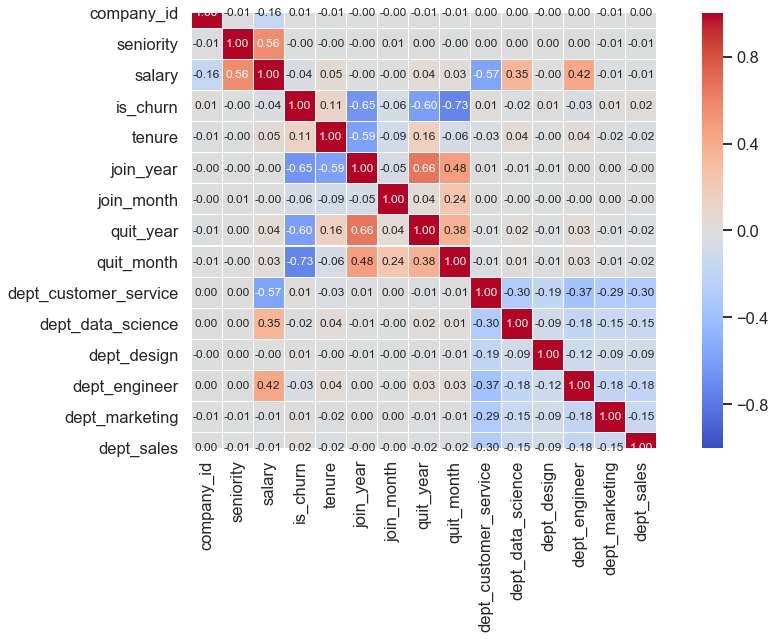

In [12]:
# Correlation with the target variable
corr_data = pd.get_dummies(data.drop(["join_date","quit_date","employee_id"],axis =1)).corr()

# Plot the correlation heat map
sns.set(style="white",context="talk")
plt.subplots(figsize=(16,8))
sns.heatmap(corr_data, square=True, cmap = "coolwarm",fmt='.2f',cbar_kws={"shrink": 1},
               annot=True,annot_kws={"size": 12} ,vmax=1,vmin=-1,linewidths=0.05,linecolor='white')
plt.show()

Interestingly, we notice that the **join year, quit month as well as the quit year** is highly correlated with whether an employee resigns. My preliminary hypothesis is that the time factor is an important factor in determining employee retention. Other important variables include tenure and salary, but the magnitude of correlation is smaller compared to the time factor

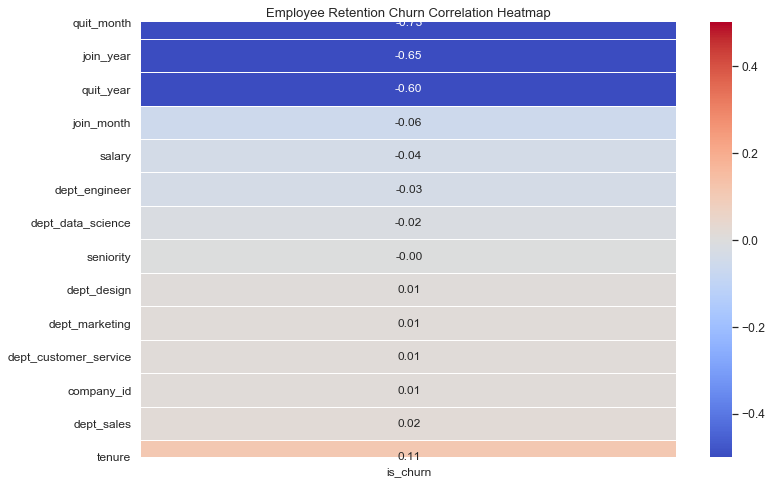

In [13]:
# Correlation with the target variable
sns.set(style="white",context="talk")
corr_data  = pd.get_dummies(data.drop(["join_date","quit_date","employee_id"],axis =1)).corr()

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.1)
ax = sns.heatmap(corr_data.loc[:,['is_churn']].drop("is_churn",axis=0).sort_values(by="is_churn"),fmt='.2f',cbar_kws={"shrink": 1},
               annot=True,annot_kws={"size": 12} ,vmax=0.5,vmin=-0.5,cmap='coolwarm',linewidths=0.05,linecolor='white')
ax.set(title= "Employee Retention Churn Correlation Heatmap")
ax.tick_params(labelsize=12)

### 3-2. Single-variate Analysis

#### Churn

In [14]:
print(f"Among the 24,700 employees in our retention dataset, 55% (13,508) of them resign during 2011/01/24 to 2015/12/13 \n")
pd.DataFrame({
          "value_counts": data.is_churn.value_counts(),
          "value_percentage": round(data.is_churn.value_counts()/data.is_churn.count(),2)})

Among the 24,700 employees in our retention dataset, 55% (13,508) of them resign during 2011/01/24 to 2015/12/13 



,value_counts,value_percentage
1,13508,0.55
0,11192,0.45


#### Join_Year

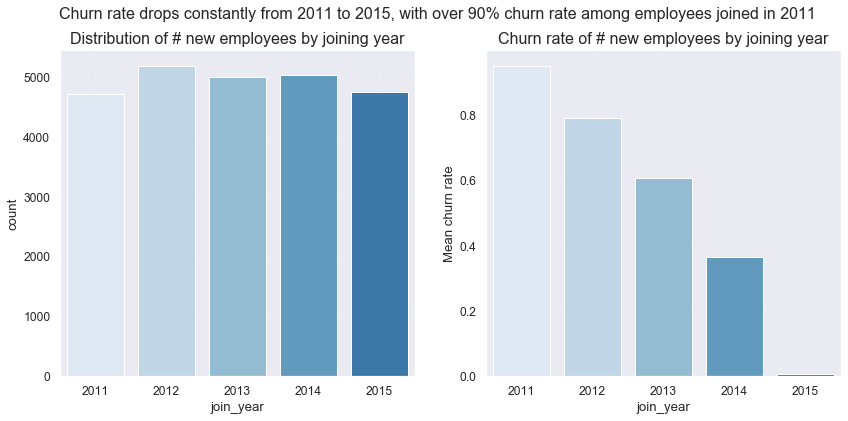

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(x='join_year', data=data,ax=axes[0],palette=sns.color_palette("Blues"))
axes[0].set_title('Distribution of # new employees by joining year', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="join_year")["is_churn"].count().reset_index()

sns.barplot(x='join_year', y='is_churn', data=data,ci=0,ax=axes[1],palette=sns.color_palette("Blues"))
axes[1].set_title('Churn rate of # new employees by joining year', fontsize=16)
axes[1].set_ylabel("Mean churn rate")
axes[1].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="join_year")["is_churn"].mean().reset_index()


fig.suptitle("Churn rate drops constantly from 2011 to 2015, with over 90% churn rate among employees joined in 2011", fontsize = 16)
plt.show()

#### Join_Month

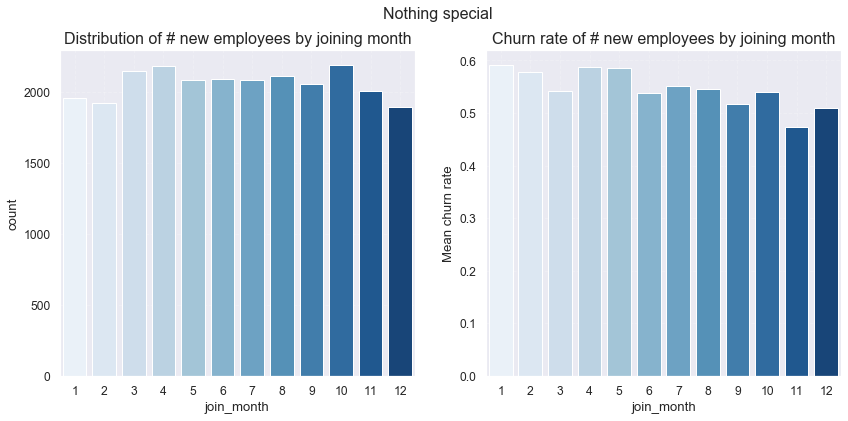

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(x='join_month', data=data,ax=axes[0],palette=sns.color_palette("Blues",12))
axes[0].set_title('Distribution of # new employees by joining month', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="join_month")["is_churn"].count().reset_index()

sns.barplot(x='join_month', y='is_churn', data=data,ci=0,ax=axes[1],palette=sns.color_palette("Blues",12))
axes[1].set_title('Churn rate of # new employees by joining month', fontsize=16)
axes[1].set_ylabel("Mean churn rate")
axes[1].grid(linestyle="--", alpha=0.2)
group_values = data.groupby(by="join_month")["is_churn"].mean().reset_index()


fig.suptitle("Nothing special", fontsize = 16)
plt.show()

#### Quit_Year & Quit_Month

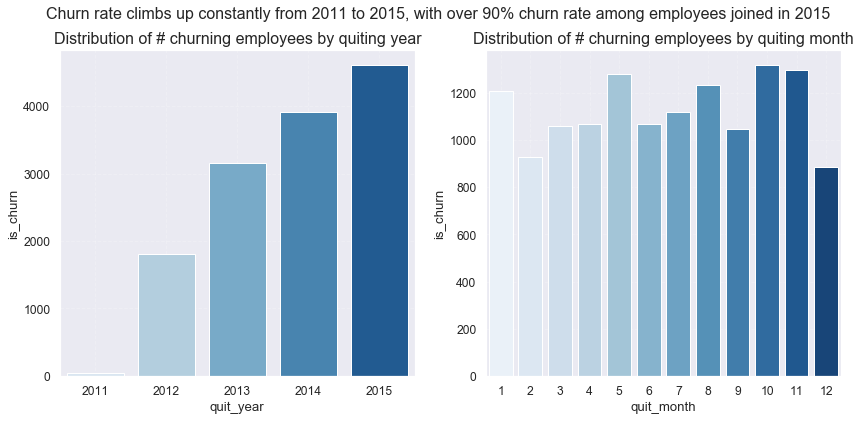

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.barplot(x='quit_year',y="is_churn" ,data=data.groupby("quit_year").is_churn.sum().reset_index(),
              ax=axes[0],palette=sns.color_palette("Blues",5))
axes[0].set_title('Distribution of # churning employees by quiting year', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(x='quit_month',y="is_churn" ,data=data.groupby("quit_month").is_churn.sum().reset_index(),
              ax=axes[1],palette=sns.color_palette("Blues",12))
axes[1].set_title('Distribution of # churning employees by quiting month', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

fig.suptitle("Churn rate climbs up constantly from 2011 to 2015, with over 90% churn rate among employees joined in 2015", fontsize = 16)
plt.show()

#### Tenure

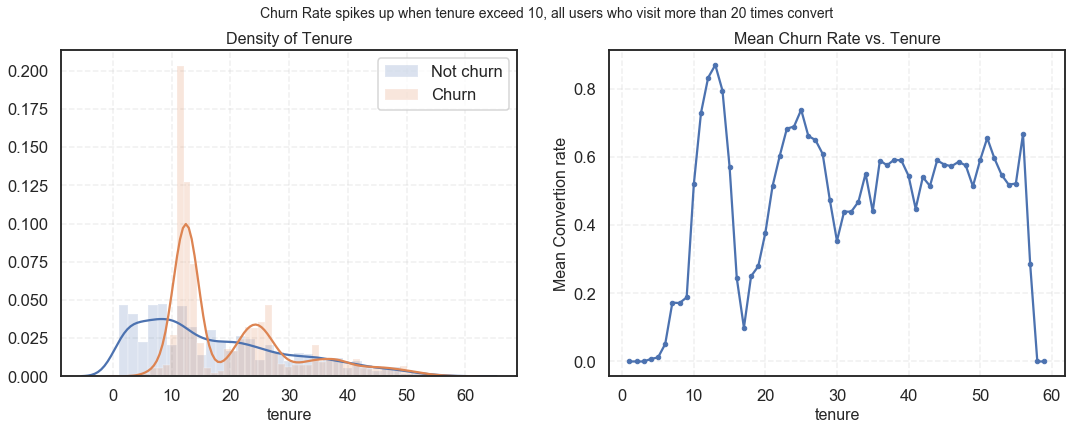

In [18]:
# Visualization of different sources
sns.set(style="white",context="talk")
grouped = data.groupby('tenure')["is_churn"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['is_churn'] == 0]['tenure'],
             label='Not churn', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['is_churn'] == 1]['tenure'], 
             label='Churn', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of Tenure', fontsize=16)
axes[0].set_xlabel('tenure',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

axes[1].plot(grouped['tenure'], grouped['is_churn'], '.-')
axes[1].set_title('Mean Churn Rate vs. Tenure', fontsize=16)
axes[1].set_xlabel('tenure',fontsize = 16)
axes[1].set_ylabel('Mean Convertion rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Churn Rate spikes up when tenure exceed 10, all users who visit more than 20 times convert", fontsize = 14)
plt.show()

#### Seniority

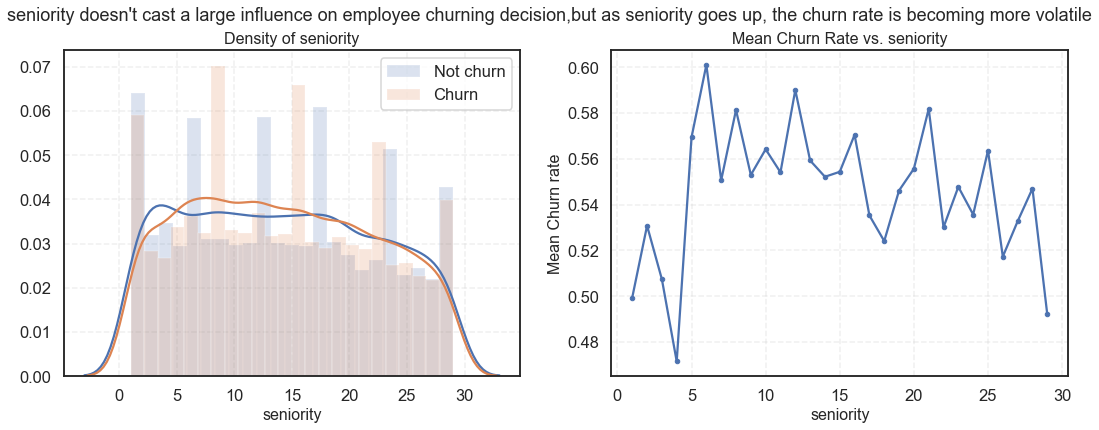

In [19]:
# Visualization of different sources
sns.set(style="white",context="talk")
grouped = data.groupby('seniority')["is_churn"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['is_churn'] == 0]['seniority'],
             label='Not churn', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['is_churn'] == 1]['seniority'], 
             label='Churn', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of seniority', fontsize=16)
axes[0].set_xlabel('seniority',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

axes[1].plot(grouped['seniority'], grouped['is_churn'], '.-')
axes[1].set_title('Mean Churn Rate vs. seniority', fontsize=16)
axes[1].set_xlabel('seniority',fontsize = 16)
axes[1].set_ylabel('Mean Churn rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("seniority doesn't cast a large influence on employee churning decision,but as seniority goes up, the churn rate is becoming more volatile", 
             fontsize = 18)
plt.show()

#### Salary

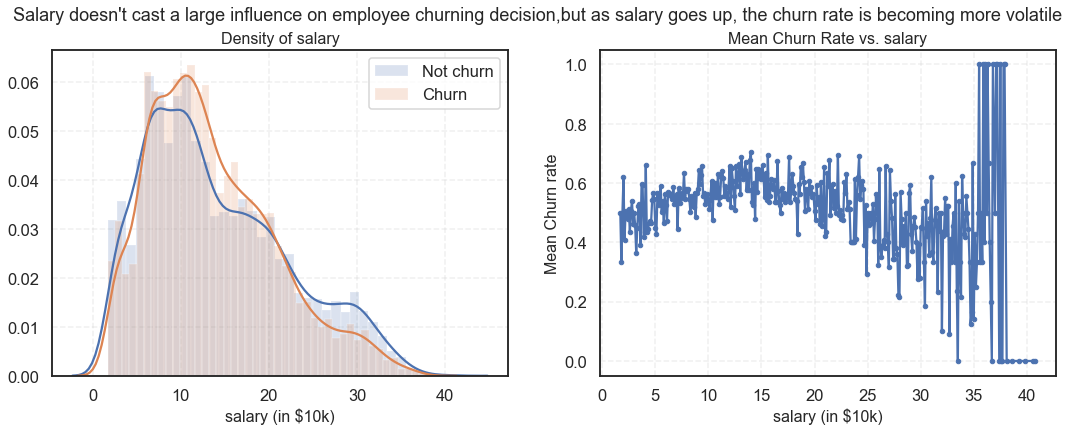

In [20]:
# Visualization of different sources
sns.set(style="white",context="talk")
grouped = data.groupby('salary')["is_churn"].mean().reset_index()
hist_kws={'histtype': 'bar', 'alpha': 0.2}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['is_churn'] == 0]['salary']/10000,
             label='Not churn', ax=axes[0], hist_kws=hist_kws)
sns.distplot(data[data['is_churn'] == 1]['salary']/10000, 
             label='Churn', ax=axes[0], hist_kws=hist_kws)
axes[0].set_title('Density of salary', fontsize=16)
axes[0].set_xlabel('salary (in $10k)',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

axes[1].plot(grouped['salary']/10000, grouped['is_churn'], '.-')
axes[1].set_title('Mean Churn Rate vs. salary', fontsize=16)
axes[1].set_xlabel('salary (in $10k)',fontsize = 16)
axes[1].set_ylabel('Mean Churn rate',fontsize = 16)
axes[1].grid(linestyle="--", alpha=0.3)

fig.suptitle("Salary doesn't cast a large influence on employee churning decision,but as salary goes up, the churn rate is becoming more volatile", 
             fontsize = 18)
plt.show()

#### Company

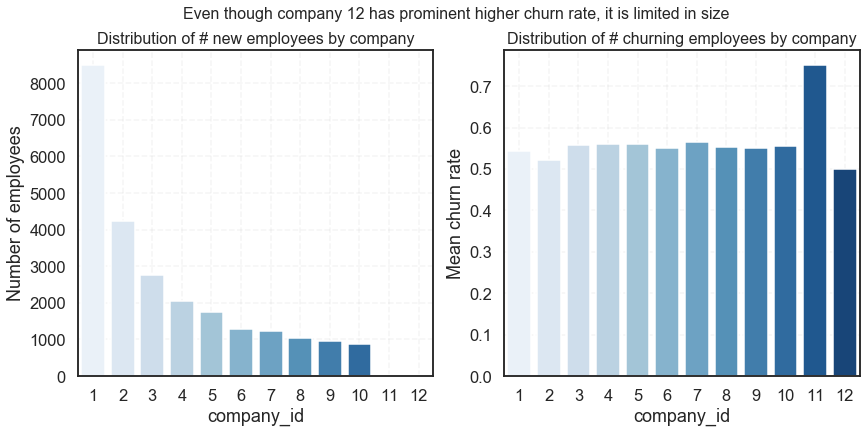

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.countplot(x='company_id', data=data,ax=axes[0],palette=sns.color_palette("Blues",12))
axes[0].set_title('Distribution of # new employees by company', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)
axes[0].set_ylabel("Number of employees")

sns.barplot(x='company_id',y="is_churn" ,data=data.groupby("company_id").is_churn.mean().reset_index(),
              ax=axes[1],palette=sns.color_palette("Blues",12))
axes[1].set_title('Distribution of # churning employees by company', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)
axes[1].set_ylabel("Mean churn rate")

fig.suptitle("Even though company 12 has prominent higher churn rate, it is limited in size", fontsize = 16)
plt.show()

# 4. Modeling

### 4-1. Random Forest 

In [22]:
data['join_year'] = data['join_year'].map(str)  
data['join_month'] = data['join_month'].map(str)  
data['quit_year'] = data['quit_year'].map(str)  
data['quit_month'] = data['quit_month'].map(str)  
data['company_id'] = data['company_id'].map(str)  

In [23]:
data_dm = pd.get_dummies(data.drop(["join_date","quit_date","employee_id"],axis=1))

In [24]:
x = data_dm.drop(["is_churn"],axis=1)
y = data_dm["is_churn"]

In [25]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,80,100], "max_depth":[3,5,7], "min_samples_split" :[2,5,8], "min_samples_leaf":[2,5,8]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "roc_auc", n_iter = 15)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_depth': 5}
0.996912955465587


### 4-2. Feature Selection (RFE)

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def rfe_cv(clf, x_train, y_train, min_features_to_select):

    rfecv = RFECV(estimator = clf, step=1, cv=StratifiedKFold(2),min_features_to_select = min_features_to_select,
                  scoring='roc_auc')

    rfecv.fit(x_train, y_train.values.ravel())
    print(f"Optimal number of features : {rfecv.n_features_}, the optimal log_loss score: {rfecv.grid_scores_.max()}\n")
    print(f"The {rfecv.n_features_} features selected: {x_train.columns[rfecv.support_].values}")

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, marker = "o", markersize = 3)
    #plt.plot(range(len(rfecv.grid_scores_)),
     #        rfecv.grid_scores_, marker = "o", markersize = 3)
    plt.grid(linestyle="--", alpha=0.3)
    plt.axvline(x = rfecv.n_features_, ls=":",c="green") 
    #plt.axhline(y = rfecv.grid_scores_.max(), ls=":", c="green")
    plt.text(rfecv.n_features_, rfecv.grid_scores_.max(),(rfecv.n_features_,round(rfecv.grid_scores_.max(),4)),color='green')
    plt.show()
    return rfecv

Optimal number of features : 34, the optimal log_loss score: 0.9988630005920299

The 34 features selected: ['seniority' 'salary' 'tenure' 'company_id_2' 'dept_customer_service'
 'join_year_2011' 'join_year_2012' 'join_year_2013' 'join_year_2014'
 'join_year_2015' 'join_month_1' 'join_month_10' 'join_month_12'
 'join_month_2' 'join_month_3' 'join_month_6' 'join_month_7'
 'join_month_8' 'join_month_9' 'quit_year_2012' 'quit_year_2013'
 'quit_year_2014' 'quit_year_2015' 'quit_month_1' 'quit_month_10'
 'quit_month_11' 'quit_month_12' 'quit_month_3' 'quit_month_4'
 'quit_month_5' 'quit_month_6' 'quit_month_7' 'quit_month_8'
 'quit_month_9']


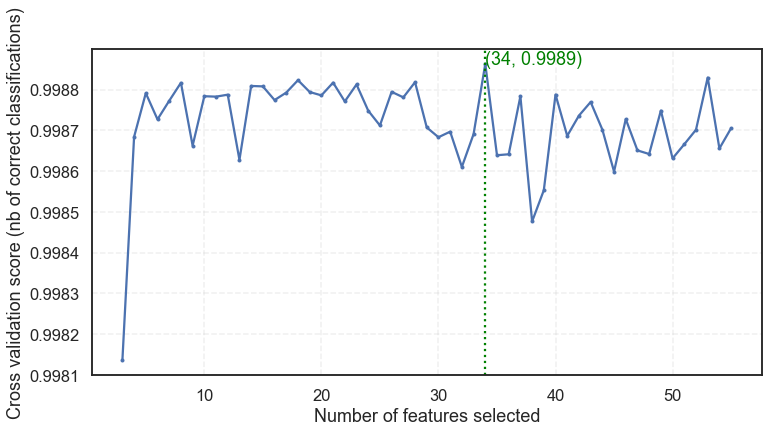

In [28]:
rf_rfecv = rfe_cv(rf_clf_best, x_train, y_train, min_features_to_select = 3)

In [29]:
rf_parameters = {"n_estimators":[40,50,60], "max_depth":[4,5,6], "min_samples_split" :[4,5,6], "min_samples_leaf":[7,8,9]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "neg_log_loss", n_iter = 15)
rf_random_search.fit(x_train[x_train.columns[rf_rfecv.support_].values], y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train[x_train.columns[rf_rfecv.support_].values], y_train))

{'n_estimators': 60, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 6}
0.996912955465587


In [30]:
fea_imp = pd.DataFrame({"importance":[round(x,4) for x in rf_clf_best.feature_importances_],
                        "feature":x_train.columns[rf_rfecv.support_].values}).sort_values(by = "importance", ascending = False)


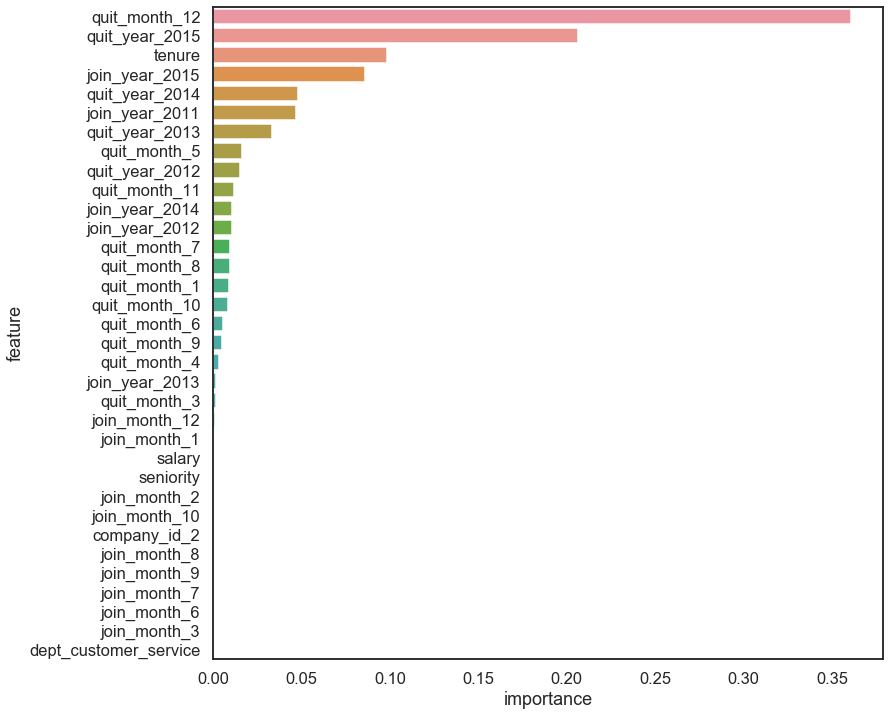

In [31]:
f = plt.figure(figsize = (12,12))
sns.barplot(x = "importance", y = "feature", data = fea_imp)


# 5. Evaluation

In [51]:
train_true = y_train
valid_true = y_valid

train_pred = rf_clf_best.predict_proba(x_train[x_train.columns[rf_rfecv.support_].values])[:,1]
valid_pred = rf_clf_best.predict_proba(x_valid[x_train.columns[rf_rfecv.support_].values])[:,1]

In [52]:
# Make predictions

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

In [53]:
# F1-score = 2 * precision*recall / (precision+recall)
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),target_names = ["not converted:0","converted:1"]))

                 precision    recall  f1-score   support

not converted:0       0.99      1.00      1.00      2196
    converted:1       1.00      0.99      1.00      2744

       accuracy                           1.00      4940
      macro avg       1.00      1.00      1.00      4940
   weighted avg       1.00      1.00      1.00      4940



In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

# Main Findings

1. Month: lots of people quit on December and May
2. Year: lots of people quit on 2015, after controlling the effect that most of employees join in 2011
3. Tenure: tenure is a important factor in predicting employee retention. Specifically, people tends to leave the company after 10~15 months joining
4. Seniority & Salary: much to my surprise, seniority and salary are not important factors. 